# Class activation maps (CAM) 
https://debuggercafe.com/basic-introduction-to-class-activation-maps-in-deep-learning-using-pytorch/

Class activation maps (CAM) are a visualization technique used to understand the regions of an image that a neural network uses to classify it into a specific category. CAM helps to explain the decision made by a neural network by highlighting the areas of the image that were most important for the classification.

In PyTorch, you can generate class activation maps by following these steps:

In [1]:
#!/usr/bin/env python

import cv2
import argparse

from torch import topk
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

import time
import os
import copy
import random

import os
import pandas as pd
from torchvision.io import read_image

from torch.utils import data
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor


from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from torch.nn import Conv2d
from torch import optim

import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo

torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True


import pandas as pd
import pickle



In [2]:
with open("Data/MoS2_Analysis_Data_trained2", "rb") as fp:   # Unpickling
    MoS2_Proj1_Class_Data = pickle.load(fp)

#features = MoS2_ImageNet_100_data[0]
dff = pd.DataFrame(MoS2_Proj1_Class_Data)
print(dff.keys())
#T_target = np.array(list(df['T']))
features = np.array(list(dff['ImageNet']))

Index(['sampleId', 'sampleLabel', 'image', 'T', 'ImageNet', 'MicroNet'], dtype='object')


In [3]:

with open("Data/MoS2_Analysis_Processed_Data2", "rb") as fp:   # Unpickling
  MoS2_data = pickle.load(fp)

df = pd.DataFrame(MoS2_data)
T = df['T']

T_classes = {900.0: 0, 950.0: 1, 1000.0: 2}
#print(MoS2_activities_substrate2['T'])
T_target = [T_classes[T[index]] for index, item in enumerate(T)]
sampleId = df['sampleId']
data_image = np.array([np.array(item) for item in df['image']])
Substrate = np.array(df['substrate'].tolist())
Time = np.array(df['time'].tolist())
#T_target = np.array(T_target).reshape(len(T_target),1)
print(len(T_target))

Data_CNN = data_image
print(Data_CNN.shape)

262
(262, 224, 224)


In [2]:

with open("Data/MoS2_Analysis_Processed_Data2", "rb") as fp:   # Unpickling
  MoS2_data = pickle.load(fp)

df = pd.DataFrame(MoS2_data)
T = df['T']

T_classes = {900.0: 0, 950.0: 1, 1000.0: 2}
#print(MoS2_activities_substrate2['T'])
T_target = [T_classes[T[index]] for index, item in enumerate(T)]
sampleId = df['sampleId']
data_image = np.array([np.array(item) for item in df['image']])
Substrate = np.array(df['substrate'].tolist())
Time = np.array(df['time'].tolist())
#T_target = np.array(T_target).reshape(len(T_target),1)
print(len(T_target))

Data_CNN = data_image
print(Data_CNN.shape)
Data_CNN_rgb = np.repeat(Data_CNN[..., np.newaxis], 3, -1)
print(Data_CNN_rgb.shape)
Data_CNN_rgb = Data_CNN_rgb.transpose(0, 3, 1, 2)/255
print(Data_CNN_rgb.shape)


from sklearn.model_selection import train_test_split


from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedGroupKFold

X = Data_CNN_rgb
Y = np.array(T_target)
groups = np.array(sampleId)

def stratified_train_test_group_kfold(X, Y, groups, n_splits, test_fold):

    group_kfold1 = StratifiedGroupKFold(n_splits=n_splits)

    print(type(group_kfold1.split(X, Y, groups)))
    Train_indices = []
    test_indices = []
    for (i, j) in group_kfold1.split(X, Y, groups):
        Train_indices.append(i)
        test_indices.append(j)

    Train_X = X[Train_indices[test_fold]]
    Train_Y = Y[Train_indices[test_fold]]
    Train_groups = groups[Train_indices[test_fold]]
    test_groups = groups[test_indices[test_fold]]
    test_X = X[test_indices[test_fold]]
    test_Y = Y[test_indices[test_fold]]

    return Train_groups, test_indices, Train_X, Train_Y, test_X, test_Y


262
(262, 224, 224)
(262, 224, 224, 3)
(262, 3, 224, 224)


In [3]:
transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.RandomRotation(degrees= (0, 180)),
      transforms.RandomHorizontalFlip(0.5),
      transforms.RandomVerticalFlip(0.5),
      transforms.ToTensor(),
      #transforms.Normalize(mean=mean, std=std),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

transform_test = transforms.Compose([
      transforms.ToPILImage(),
      transforms.ToTensor(),
      #transforms.Normalize(mean=mean, std=std),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])


class Dataset():
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels, transform):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = self.transform(ID)
        y = self.labels[index]
        return X, y



    
def data_loader_fn(x, y, transform, batch_size):
    target = np.array(y)
    data = np.array(x)
    labels_unique, class_sample_count = np.unique(target, return_counts=True)
    weight = [sum(class_sample_count) / c for c in class_sample_count]


    samples_weight = np.array([weight[t] for t in target])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    target = torch.from_numpy(target)
    data = torch.from_numpy(data)
    #train_dataset = torch.utils.data.TensorDataset(data, target)

    dataset = Dataset(data, target, transform)

    data_loader = DataLoader(
        dataset, batch_size=batch_size, num_workers=1, sampler=sampler, drop_last=False)

    return data_loader


def data_loader_test_fn(x, y, transform, batch_size):
    data = torch.tensor(x)
    target = torch.tensor(y)
    dataset = Dataset(data, target, transform)

    data_loader = DataLoader(dataset,  batch_size = batch_size, shuffle = False, drop_last=False)#, num_workers= 2)
    return data_loader


def accuracy_cnn_fn(trained_model, data_loader, data_type):
    correct = 0
    total = 0
    trained_model.eval()
    #with torch.no_grad():
    for data in data_loader:
        images, labels = data
#        images, labels = images.to(device), labels.to(device)

        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        #print(labels)
        #print("......")
        #print(predicted)        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
   # print(f'Accuracy of the network on the {total} {data_type} images: {accuracy :.1f} %')
    
    return accuracy, labels, predicted

    
def cm_cnn_fn(trained_model, data_loader, data_type):
    correct = 0
    total = 0
    trained_model.eval()
    #with torch.no_grad():
    for data in data_loader:
        images, labels = data
#        images, labels = images.to(device), labels.to(device)

        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        cm_test = confusion_matrix(labels.cpu(), predicted.cpu())
        #print(f'{data_type} confusion matrix: {cm_test}')

    return cm_test



def pretrained_model():

    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    model.fc = nn.Sequential(nn.Linear(512, 3)
                                     )
    #model.to(device)

    return model


    
    
with open("Model/CNN_Final_best_variables", "rb") as fp:   # Unpickling
    best_variables = pickle.load(fp)


fold = 7
learning_rate = best_variables[fold]['learning_rate']
batch_size = best_variables[fold]['batch_size']
epochs = best_variables[fold]['epochs']


model = pretrained_model()#.to(device)


#PATH = 'Model/model_final_micro_6_class_T.pth'
#PATH = 'Model/CNN_Final_model_image_7_class_T.pth'
PATH = 'Model/model_final_micro_7_class_T.pth'
model.load_state_dict(torch.load(PATH))
model.eval()


train_val_groups, test_indices, train_val_X, train_val_Y, test_X, test_Y = stratified_train_test_group_kfold(X, Y, groups, n_splits=10, test_fold=0)



train_group, val_indices, train_X, train_Y, val_X, val_Y = stratified_train_test_group_kfold(train_val_X, train_val_Y, train_val_groups, n_splits=10, test_fold=fold)

#test_duplicates = [5, 6, 7, 10, 13, 16, 18, 25]

print(f'train_X.shape: {train_X.shape}, train_Y.shape: {np.array(train_Y).shape}')
print(f'val_X.shape: {val_X.shape}, val_Y.shape: {np.array(val_Y).shape}')
print(f'test_X2.shape: {test_X.shape}, test_Y.shape: {np.array(test_Y).shape}')

train_loader= data_loader_test_fn(train_X, train_Y, transform_test, batch_size=len(train_Y))
val_loader = data_loader_test_fn(val_X, val_Y, transform, batch_size)

test_loader = data_loader_test_fn(test_X, test_Y, transform_test, batch_size=len(test_Y))

#acc_test = accuracy_cnn_fn(model, val_loader2, 'test')
acc_test, test_labels, test_predicted = accuracy_cnn_fn(model, test_loader, 'test')
acc_train, train_labels, train_predicted = accuracy_cnn_fn(model, train_loader, 'test')
#cm_test = cm_cnn_fn(model, val_loader2, 'test')

print(acc_test)
#print (cm_test)
        

<class 'generator'>
<class 'generator'>
train_X.shape: (212, 3, 224, 224), train_Y.shape: (212,)
val_X.shape: (23, 3, 224, 224), val_Y.shape: (23,)
test_X2.shape: (27, 3, 224, 224), test_Y.shape: (27,)
66.66666666666667


At line 12, we are calling the load_synset_classes() function by passing the class file path as the argument. Printing all_classes will give the following result now.

# Plotting Test Data

In [4]:
test_labels1 = test_labels.cpu().tolist()
test_predicted1 = test_predicted.cpu().tolist()
print(test_labels1)

print(test_predicted1)



[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2]
[0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2]


In [5]:
# Reordering the the test set with 900, 950, 1000 points

print(test_X.shape)
class_labels = {0:[], 1:[], 2:[]}

for index, item in enumerate(test_labels1):
    class_labels[item].append(index)
        
print(class_labels)

image_order = []
for key in class_labels.keys():
    image_order += class_labels[key]


image_label_order = np.array(test_labels1)[image_order]
image_pred_order = np.array(test_predicted1)[image_order]

print(image_order)
print(image_label_order)
print(image_pred_order)

(27, 3, 224, 224)
{0: [0, 1, 2], 1: [3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 20, 21], 2: [11, 12, 13, 17, 18, 19, 22, 23, 24, 25, 26]}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 20, 21, 11, 12, 13, 17, 18, 19, 22, 23, 24, 25, 26]
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
[0 1 2 1 2 1 0 2 1 1 1 1 1 0 2 0 2 1 2 2 2 2 2 2 2 2 2]


In [6]:
label_pred_match = []
for index, item in enumerate(image_label_order):
    if item == image_pred_order[index]:
        label_pred_match.append(1)
    else:
        label_pred_match.append(0)
print(label_pred_match)

[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


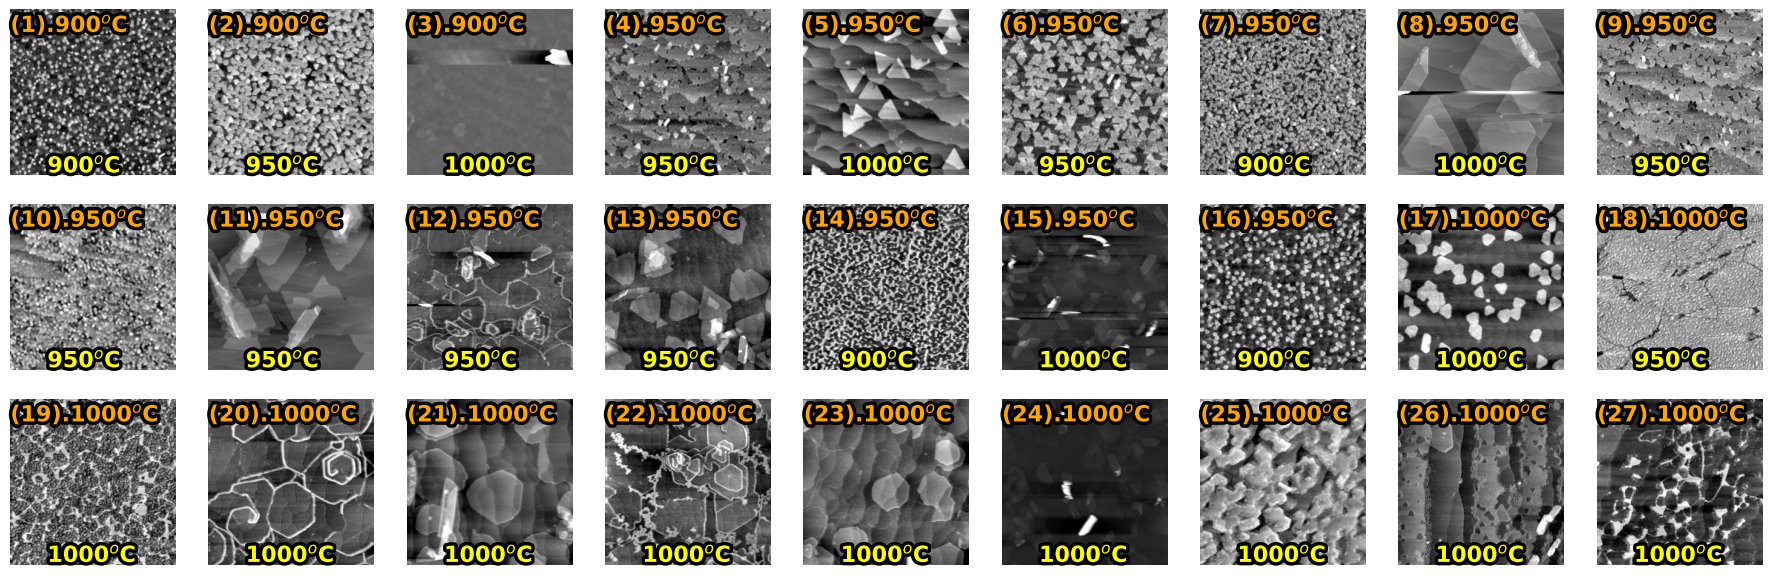

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
#fig, ax = plt.subplots(figsize=(20, 8))
#class_labels = {0:[]}
class_dict = {0:900, 1:950, 2:1000}
rows = 3
columns = 9
i = 0
x_point1 = 0
y_point1 = 30
x_point2 = 50
y_point2 = 220
fig, ax = plt.subplots(rows, columns, figsize=(18, 6))

for row in range(rows):
    for column in range(columns):
    
        image = test_X[image_order[i]].transpose(1, 2, 0)#.to(device)

        ax[row, column].imshow(image, cmap='binary')
        ax[row, column].axis('off')
        #ax[row, column].text(x_point1, y_point1, f'({i+1}).{class_dict[image_label_order[i]]}$^o$C',c='red', fontsize='16', weight='bold', bbox=dict(fill=False, edgecolor='red', linewidth=0))
        
        #ax[row, column].text(x_point2, y_point2, f'{class_dict[image_pred_order[i]]}$^o$C',c='yellow', fontsize='16', weight='bold', bbox=dict(fill=False, edgecolor='red', linewidth=0))
       
        txt = ax[row, column].text(x_point1, y_point1,f'({i+1}).{class_dict[image_label_order[i]]}$^o$C', size=16,  weight='bold',color='orange')
        txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='black')])
        txt2 = ax[row, column].text(x_point2, y_point2,f'{class_dict[image_pred_order[i]]}$^o$C', size=16, weight='bold', color='yellow')
        txt2.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='black')])
        #plt.draw()
        i +=1
           
plt.savefig("Result/test_images.pdf", format="pdf", bbox_inches="tight")
fig.tight_layout()
plt.show()

In [21]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

## Data for CAM and Occlusion

In [22]:
train_loader= data_loader_test_fn(train_X, train_Y, transform_test, batch_size=len(train_Y))

acc_train, train_labels, train_predicted = accuracy_cnn_fn(model, train_loader, 'test')

In [23]:
print(acc_train)
train_labels1 = train_labels.cpu().tolist()
train_predicted1 = train_predicted.cpu().tolist()
train_correctly_predicted = {0:[], 1:[], 2:[]}
for index, item in enumerate(train_labels1):
    if item == train_predicted1[index]:
        train_correctly_predicted[item].append(index)

print(train_correctly_predicted)
    

90.56603773584905
{0: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 64, 67, 83, 92, 101, 182], 1: [19, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 58, 60, 61, 65, 66, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 91, 100, 102, 104, 105, 108, 109, 110, 111, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 153, 154, 155, 160, 161, 162, 163, 164, 165, 166, 170, 171, 172, 173, 174, 175, 190], 2: [0, 21, 42, 63, 68, 82, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95, 96, 97, 98, 99, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 156, 157, 158, 159, 167, 168, 176, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211]}


In [20]:
print(train_labels1)

[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [21]:
print(train_predicted1)

[2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [33]:
transform_test = transforms.Compose([
     
      transforms.ToTensor(),
     
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])




# Occlusion Attribution

In [37]:
import torchvision
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

from captum.attr import Occlusion 
import numpy as np
from visualization import * 

occlusion = Occlusion(model.double())
images_indices_900 = train_correctly_predicted[0]
images_indices_950 = train_correctly_predicted[1]
images_indices_1000 = train_correctly_predicted[2][10:]
strides = (3, 5, 5)#9, 9               # smaller = more fine-grained attribution but slower
target=2,                       # Labrador index in ImageNet 
sliding_window_shapes=(3,15, 15)#45, 45  # choose size enough to change object appearance
baselines = 0     

def get_occlusion_images(temp, image_indices):
    
    for i in range(4):
   

        image = train_X[image_indices[i]].transpose(1, 2, 0)
        print(image.shape)

        image_tensor = transform_test(image)
            # add batch dimension
        image_tensor = image_tensor.unsqueeze(0)#.to(devic

                    # values to occlude the image with. 0 corresponds to gray

        attribution_1 = occlusion.attribute(image_tensor,
                                               strides = strides,
                                               target=target,
                                               sliding_window_shapes=sliding_window_shapes,
                                               baselines=baselines)

        attribution_1 = np.transpose(attribution_1.squeeze().cpu().detach().numpy(), (1,2,0))


        blended_im, blended_ax = visualize_image_attr(attribution_1, image,"blended_heat_map",sign='all',fig_size=(4,4), show_colorbar = False)

        heat_map, heat_map_ax = visualize_image_attr(attribution_1, image,"heat_map",sign='all',fig_size=(4,4), show_colorbar = False)
        
        heat_map.savefig(f'Result/heat_map_image{temp}_{i}.png')
        blended_im.savefig(f'Result/blended_image{temp}_{i}.png')

(224, 224, 3)


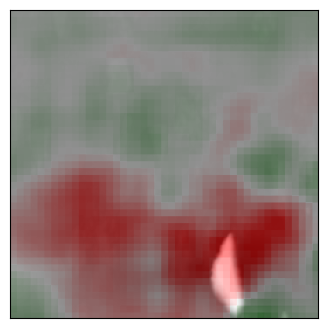

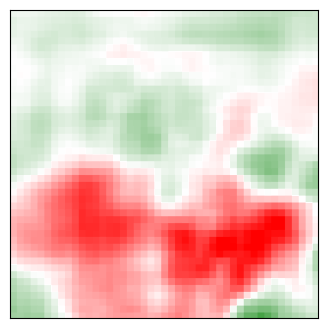

(224, 224, 3)


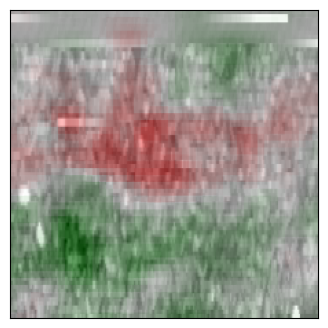

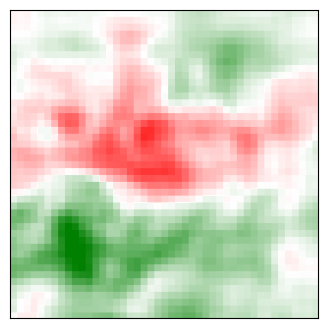

(224, 224, 3)


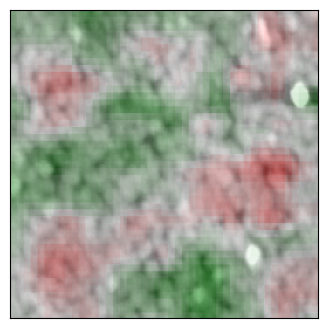

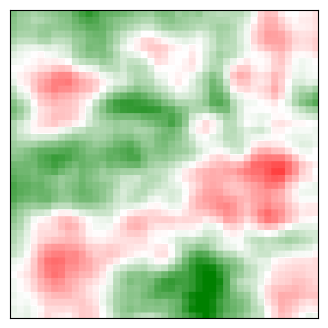

(224, 224, 3)


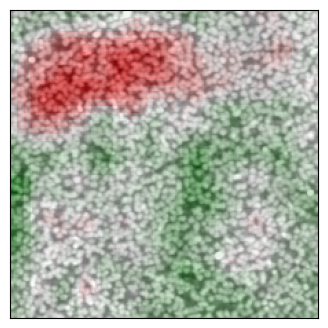

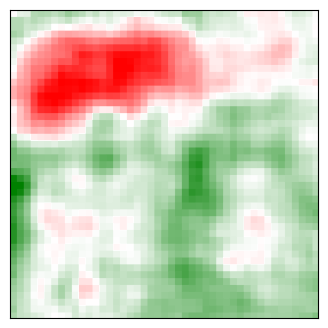

In [38]:
get_occlusion_images(900, images_indices_900)


(224, 224, 3)


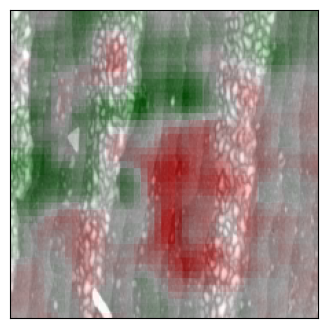

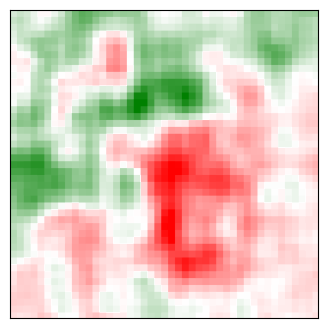

(224, 224, 3)


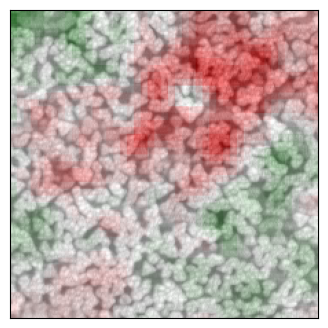

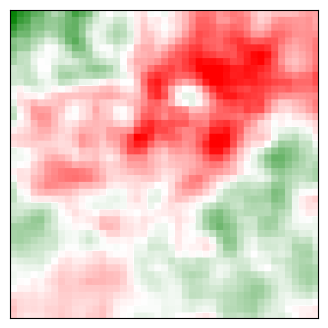

(224, 224, 3)


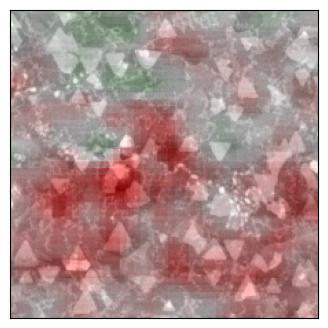

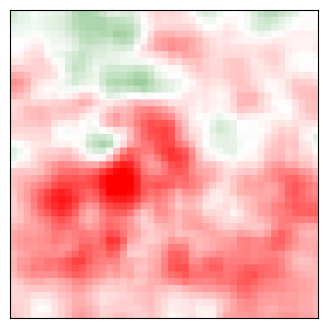

(224, 224, 3)


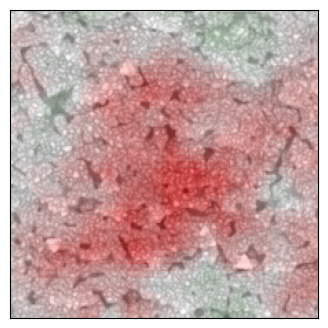

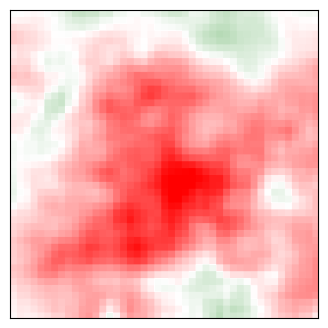

In [39]:
get_occlusion_images(950, images_indices_950)

(224, 224, 3)


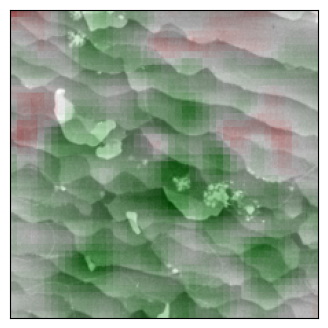

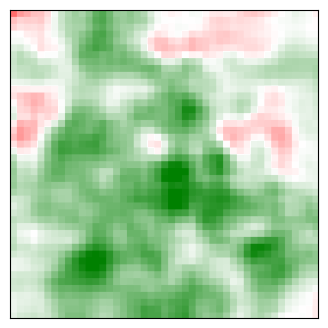

(224, 224, 3)


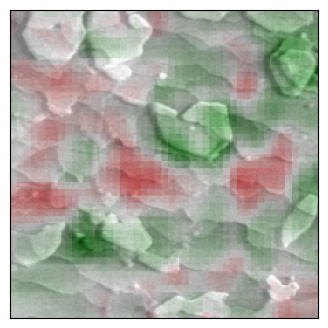

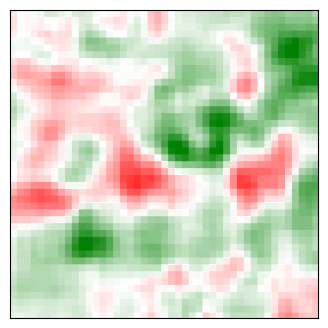

(224, 224, 3)


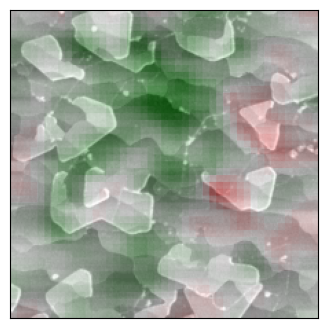

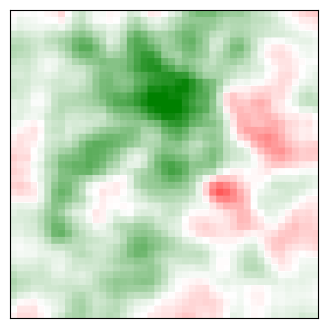

(224, 224, 3)


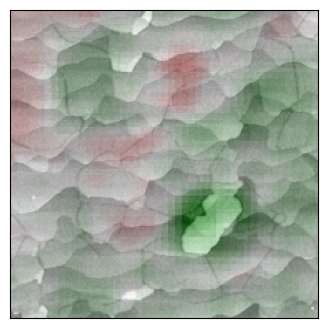

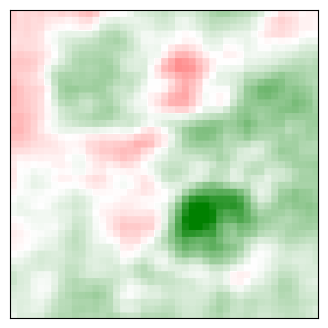

In [40]:
get_occlusion_images(1000, images_indices_1000)

float32
(400, 400, 4)


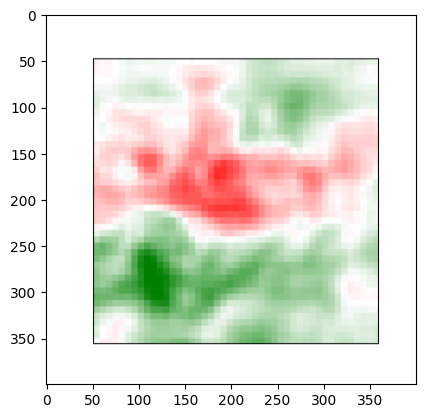

In [37]:

from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
path = 'Result/heat_map_image900_1.png'
image = image.imread(path)
# summarize shape of the pixel array
print(image.dtype)
print(image.shape)
# display the array of pixels as an image
pyplot.imshow(image)
pyplot.show()

In [28]:
print(type(image))
print(image_tensor.shape)
print(image_center.shape)
print(type(image_center))

<class 'numpy.ndarray'>
torch.Size([4, 400, 400])
(295, 295, 4)
<class 'numpy.ndarray'>


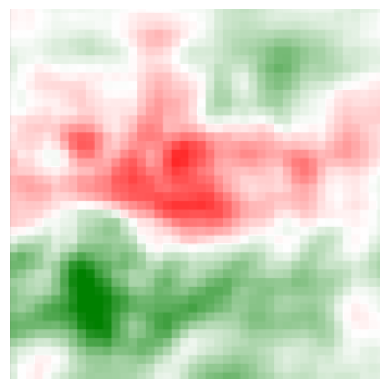

In [38]:
size = 297
#image_center = transforms.CenterCrop(size=size)(image)

image_tensor = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)

cropper = transforms.CenterCrop(size=(size, size))
image_center = cropper(image_tensor).numpy().transpose(1, 2, 0)
pyplot.imshow(image_center)
pyplot.axis('off')
pyplot.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(212, 3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


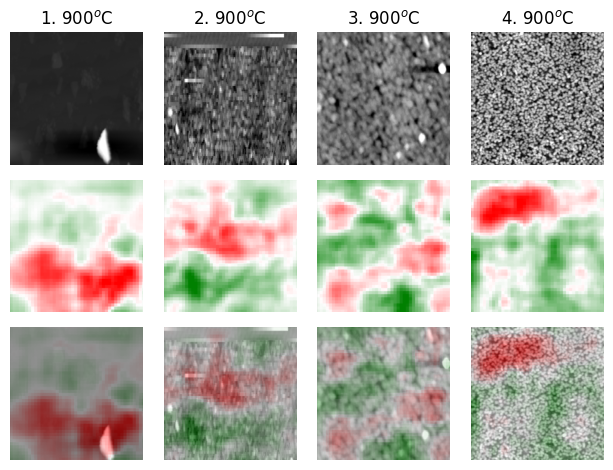

In [56]:
images_indices_900 = train_correctly_predicted[0]
images_indices_950 = train_correctly_predicted[1]
images_indices_1000 = train_correctly_predicted[2][10:]


import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot

print(train_X.shape)
_, height, width = train_X[0].shape
j = 0
k = 0
rows = 3
columns = 4
size = 297
cropper = transforms.CenterCrop(size=(size, size))

fig, ax = plt.subplots(rows, columns)
for i in range(4):

    image1 = train_X[images_indices_900[i]].transpose(1, 2, 0)


    path2 = f'Result/heat_map_image900_{i}.png'
    image2 = image.imread(path2)
    path3 = f'Result/blended_image900_{i}.png'
    image3 = image.imread(path3)    


    image_tensor2 = torch.tensor(image2.transpose(2, 0, 1), dtype=torch.float32)
    image_center2 = cropper(image_tensor2).numpy().transpose(1, 2, 0)

    image_tensor3 = torch.tensor(image3.transpose(2, 0, 1), dtype=torch.float32)
    image_center3 = cropper(image_tensor3).numpy().transpose(1, 2, 0) 
    
    ax[j, k].imshow(image1, cmap='binary')
    ax[j, k].axis('off')
    ax[j, k].set_title(f'{k+1}. 900$^o$C')# (i)')
    ax[j+1, k].imshow(image_center2,cmap='jet')
    ax[j+1, k].axis('off')
    #ax[j+1, k].set_title('(ii)')
    ax[j+2, k].imshow(image_center3,cmap='jet')
    ax[j+2, k].axis('off')
    #ax[j+2, k].set_title('(iii)')
    k += 1
    
    fig.tight_layout()
   
#plt.savefig("Result/cam_900.pdf", format="pdf", bbox_inches="tight") 
plt.show()

In [48]:
print(image.shape)
print(type(image))
transform_test = transforms.Compose([
     
      transforms.ToTensor(),
     
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

(224, 224, 3)
<class 'numpy.ndarray'>


# CAM and Occlusion

/tmp/ipykernel_2100518/2470701986.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(212, 3, 224, 224)
tensor([0.9920, 0.0063, 0.0017], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9.9941e-01, 5.7838e-04, 9.5797e-06], dtype=torch.float64)
tensor([0.9687, 0.0292, 0.0021], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9.6688e-01, 3.2602e-02, 5.1484e-04], dtype=torch.float64)


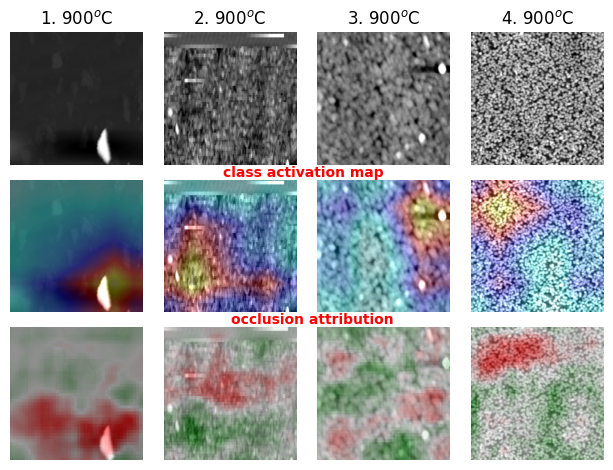

In [140]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot

images_indices_900 = train_correctly_predicted[0]
#index_0 = [1, 9, 40, 47]
index_0 = [0, 11, 14, 20]
print(train_X.shape)
_, height, width = train_X[0].shape
j = 0
k = 0
rows = 3
columns = 4

size = 297
cropper = transforms.CenterCrop(size=(size, size))

fig, ax = plt.subplots(rows, columns)
for i in range(4):

    path3 = f'Result/blended_image900_{i}.png'
    image3 = image.imread(path3)    

    image_tensor3 = torch.tensor(image3.transpose(2, 0, 1), dtype=torch.float32)
    image_center3 = cropper(image_tensor3).numpy().transpose(1, 2, 0) 
    
    

    image1 = train_X[images_indices_900[i]].transpose(1, 2, 0)
    #image = train_X[i].transpose(1, 2, 0)#.to(device)
    features_blobs = []
    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())
    model._modules.get('layer4').register_forward_hook(hook_feature)
    
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

    image_tensor = transform_test(image1)
    # add batch dimension
    image_tensor = image_tensor.unsqueeze(0)#.to(device)

    # forward pass through model
    model = model.double()
    outputs = model(image_tensor)
    # get the softmax probabilities
    probs = F.softmax(outputs).data.squeeze()
    print(probs)
    # get the class indices of top k probabilities
    class_idx = topk(probs, 1)[1].int()


    CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)

    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = np.invert(heatmap)*0.3 /255. + image1
    #cv2.imwrite('temp_1000_cam.png', result)

    
   
    ax[j, k].imshow(image1, cmap='binary')
    ax[j, k].axis('off')
    ax[j, k].set_title(f'{k+1}. 900$^o$C')# (i)')
    ax[j+1, k].imshow(result,cmap='jet')
    ax[j+1, k].axis('off')
    #ax[j+1, k].set_title('(ii)')
    ax[j+2, k].imshow(image_center3,cmap='jet')
    ax[j+2, k].axis('off')
    #ax[j+2, k].set_title('(iii)')
    k += 1
    
    fig.tight_layout()
#ax[j+1, 2].set_title('class activation map',position=(-0.1, 1), fontsize=10, fontweight='bold')
#ax[j+2, 2].set_title('occlusion attribution',position=(-0.1, -0.2), fontsize=10, fontweight='bold', color='r')   
ax[j+1, 1].text(100.0, -6.0, 'class activation map',fontsize=10, fontweight='bold', color='r') 
ax[j+2, 1].text(150.0, -8.0, 'occlusion attribution',fontsize=10, fontweight='bold', color='r') 
plt.savefig("Result/cam_occlusion_900.pdf", format="pdf", bbox_inches="tight") 
plt.show()

/tmp/ipykernel_2100518/3160888318.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(212, 3, 224, 224)
tensor([0.3663, 0.6311, 0.0026], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.0075, 0.9822, 0.0104], dtype=torch.float64)
tensor([0.0395, 0.9551, 0.0054], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.0122, 0.8701, 0.1177], dtype=torch.float64)


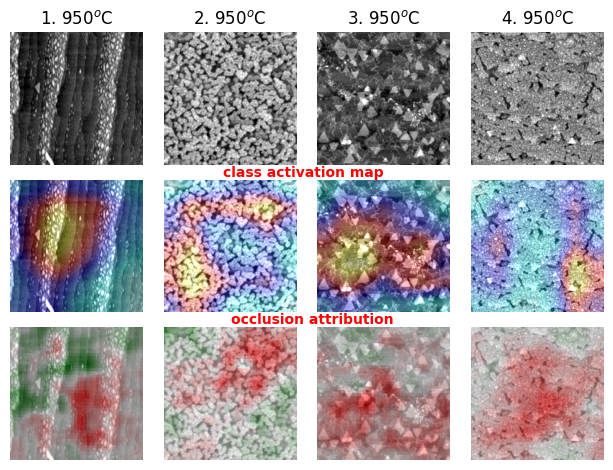

In [141]:
import matplotlib.pyplot as plt

images_indices_900 = train_correctly_predicted[0]
images_indices_950 = train_correctly_predicted[1]
images_indices_1000 = train_correctly_predicted[2][10:]

print(train_X.shape)
_, height, width = train_X[0].shape
j = 0
k = 0
rows = 3
columns = 4

size = 297
cropper = transforms.CenterCrop(size=(size, size))

fig, ax = plt.subplots(rows, columns)
for i in range(4):

    path3 = f'Result/blended_image950_{i}.png'
    image3 = image.imread(path3)    

    image_tensor3 = torch.tensor(image3.transpose(2, 0, 1), dtype=torch.float32)
    image_center3 = cropper(image_tensor3).numpy().transpose(1, 2, 0) 
    
    

    image1 = train_X[images_indices_950[i]].transpose(1, 2, 0)
    #image = train_X[i].transpose(1, 2, 0)#.to(device)
    features_blobs = []
    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())
    model._modules.get('layer4').register_forward_hook(hook_feature)
    
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

    image_tensor = transform_test(image1)
    # add batch dimension
    image_tensor = image_tensor.unsqueeze(0)#.to(device)

    # forward pass through model
    model = model.double()
    outputs = model(image_tensor)
    # get the softmax probabilities
    probs = F.softmax(outputs).data.squeeze()
    print(probs)
    # get the class indices of top k probabilities
    class_idx = topk(probs, 1)[1].int()


    CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)

    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = np.invert(heatmap)*0.3 /255. + image1
    #cv2.imwrite('temp_1000_cam.png', result)

    
   
    ax[j, k].imshow(image1, cmap='binary')
    ax[j, k].axis('off')
    ax[j, k].set_title(f'{k+1}. 950$^o$C')# (i)')
    ax[j+1, k].imshow(result,cmap='jet')
    ax[j+1, k].axis('off')
    #ax[j+1, k].set_title('(ii)')
    ax[j+2, k].imshow(image_center3,cmap='jet')
    ax[j+2, k].axis('off')
    #ax[j+2, k].set_title('(iii)')
    k += 1
    
    fig.tight_layout()
ax[j+1, 1].text(100.0, -6.0, 'class activation map',fontsize=10, fontweight='bold', color='r') 
ax[j+2, 1].text(150.0, -8.0, 'occlusion attribution',fontsize=10, fontweight='bold', color='r')    
plt.savefig("Result/cam_occlusion_950.pdf", format="pdf", bbox_inches="tight") 
plt.show()

/tmp/ipykernel_2100518/2025638716.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(212, 3, 224, 224)
tensor([4.2741e-05, 2.8356e-03, 9.9712e-01], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([4.0732e-05, 2.3800e-03, 9.9758e-01], dtype=torch.float64)
tensor([2.5499e-05, 9.3587e-04, 9.9904e-01], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.3132e-04, 8.7554e-04, 9.9899e-01], dtype=torch.float64)


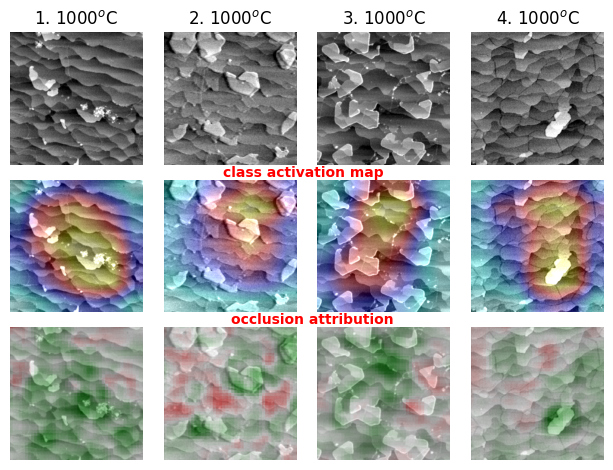

In [142]:
import matplotlib.pyplot as plt

images_indices_900 = train_correctly_predicted[0]
images_indices_950 = train_correctly_predicted[1]
images_indices_1000 = train_correctly_predicted[2][10:]

print(train_X.shape)
_, height, width = train_X[0].shape
j = 0
k = 0
rows = 3
columns = 4

size = 297
cropper = transforms.CenterCrop(size=(size, size))

fig, ax = plt.subplots(rows, columns)
for i in range(4):

    path3 = f'Result/blended_image1000_{i}.png'
    image3 = image.imread(path3)    

    image_tensor3 = torch.tensor(image3.transpose(2, 0, 1), dtype=torch.float32)
    image_center3 = cropper(image_tensor3).numpy().transpose(1, 2, 0) 
    
    

    image1 = train_X[images_indices_1000[i]].transpose(1, 2, 0)
    #image = train_X[i].transpose(1, 2, 0)#.to(device)
    features_blobs = []
    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())
    model._modules.get('layer4').register_forward_hook(hook_feature)
    
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

    image_tensor = transform_test(image1)
    # add batch dimension
    image_tensor = image_tensor.unsqueeze(0)#.to(device)

    # forward pass through model
    model = model.double()
    outputs = model(image_tensor)
    # get the softmax probabilities
    probs = F.softmax(outputs).data.squeeze()
    print(probs)
    # get the class indices of top k probabilities
    class_idx = topk(probs, 1)[1].int()


    CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)

    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = np.invert(heatmap)*0.3 /255. + image1
    #cv2.imwrite('temp_1000_cam.png', result)

    
   
    ax[j, k].imshow(image1, cmap='binary')
    ax[j, k].axis('off')
    ax[j, k].set_title(f'{k+1}. 1000$^o$C')# (i)')
    ax[j+1, k].imshow(result,cmap='jet')
    ax[j+1, k].axis('off')
    #ax[j+1, k].set_title('(ii)')
    ax[j+2, k].imshow(image_center3,cmap='jet')
    ax[j+2, k].axis('off')
    #ax[j+2, k].set_title('(iii)')
    k += 1
    
    fig.tight_layout()
    
ax[j+1, 1].text(100.0, -6.0, 'class activation map',fontsize=10, fontweight='bold', color='r') 
ax[j+2, 1].text(150.0, -8.0, 'occlusion attribution',fontsize=10, fontweight='bold', color='r')    
plt.savefig("Result/cam_occlusion_1000.pdf", format="pdf", bbox_inches="tight") 
plt.show()

# Class Activation Map

/tmp/ipykernel_2100518/2511169070.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(212, 3, 224, 224)
tensor([0.9920, 0.0063, 0.0017], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9.9941e-01, 5.7838e-04, 9.5797e-06], dtype=torch.float64)
tensor([0.9687, 0.0292, 0.0021], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9.6688e-01, 3.2602e-02, 5.1484e-04], dtype=torch.float64)


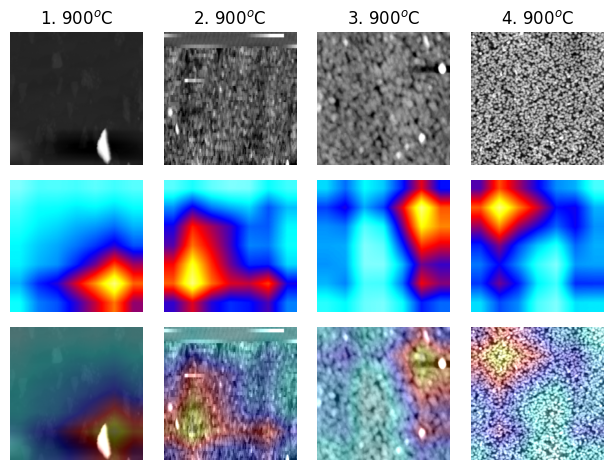

In [51]:
import matplotlib.pyplot as plt
images_indices_900 = train_correctly_predicted[0]
#index_0 = [1, 9, 40, 47]
index_0 = [0, 11, 14, 20]
print(train_X.shape)
_, height, width = train_X[0].shape
j = 0
k = 0
rows = 3
columns = 4

fig, ax = plt.subplots(rows, columns)
for i in range(4):

    image = train_X[images_indices_900[i]].transpose(1, 2, 0)
    #image = train_X[i].transpose(1, 2, 0)#.to(device)
    features_blobs = []
    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())
    model._modules.get('layer4').register_forward_hook(hook_feature)
    
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

    image_tensor = transform_test(image)
    # add batch dimension
    image_tensor = image_tensor.unsqueeze(0)#.to(device)

    # forward pass through model
    model = model.double()
    outputs = model(image_tensor)
    # get the softmax probabilities
    probs = F.softmax(outputs).data.squeeze()
    print(probs)
    # get the class indices of top k probabilities
    class_idx = topk(probs, 1)[1].int()


    CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)

    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = np.invert(heatmap)*0.3 /255. + image
    #cv2.imwrite('temp_1000_cam.png', result)

    
   
    ax[j, k].imshow(image, cmap='binary')
    ax[j, k].axis('off')
    ax[j, k].set_title(f'{k+1}. 900$^o$C')# (i)')
    ax[j+1, k].imshow(np.invert(heatmap) /255.,cmap='jet')
    ax[j+1, k].axis('off')
    #ax[j+1, k].set_title('(ii)')
    ax[j+2, k].imshow(result,cmap='jet')
    ax[j+2, k].axis('off')
    #ax[j+2, k].set_title('(iii)')
    k += 1
    
    fig.tight_layout()
   
#plt.savefig("Result/cam_900.pdf", format="pdf", bbox_inches="tight") 
plt.show()

(212, 3, 224, 224)


/tmp/ipykernel_2090062/2569118337.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.3663, 0.6311, 0.0026], dtype=torch.float64)
tensor([0.0075, 0.9822, 0.0104], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.0395, 0.9551, 0.0054], dtype=torch.float64)
tensor([0.0122, 0.8701, 0.1177], dtype=torch.float64)


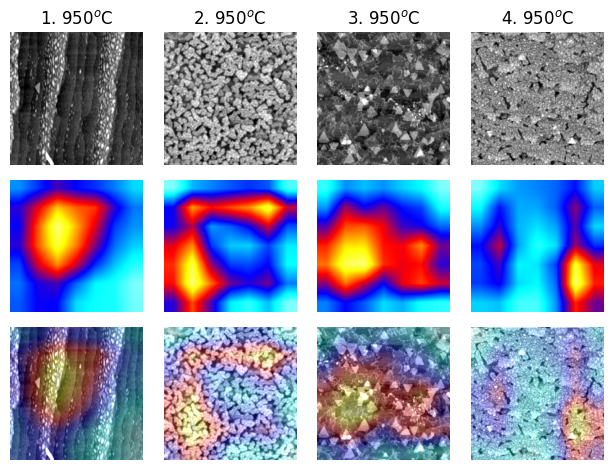

In [35]:
import matplotlib.pyplot as plt
images_indices_950 = train_correctly_predicted[1]#[10:]

print(train_X.shape)
_, height, width = train_X[0].shape
j = 0
k = 0
rows = 3
columns = 4

fig, ax = plt.subplots(rows, columns)
for i in range(4):

    image = train_X[images_indices_950[i]].transpose(1, 2, 0)
    #image = train_X[i].transpose(1, 2, 0)#.to(device)
    features_blobs = []
    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())
    model._modules.get('layer4').register_forward_hook(hook_feature)
    
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

    image_tensor = transform_test(image)
    # add batch dimension
    image_tensor = image_tensor.unsqueeze(0)#.to(device)

    # forward pass through model
    model = model.double()
    outputs = model(image_tensor)
    # get the softmax probabilities
    probs = F.softmax(outputs).data.squeeze()
    print(probs)
    # get the class indices of top k probabilities
    class_idx = topk(probs, 1)[1].int()


    CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)

    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = np.invert(heatmap)*0.3 /255. + image
    #cv2.imwrite('temp_1000_cam.png', result)

    
   
    ax[j, k].imshow(image, cmap='binary')
    ax[j, k].axis('off')
    ax[j, k].set_title(f'{k+1}. 950$^o$C')#' (i)')
    ax[j+1, k].imshow(np.invert(heatmap) /255.,cmap='jet')
    ax[j+1, k].axis('off')
    #ax[j+1, k].set_title('(ii)')
    ax[j+2, k].imshow(result,cmap='jet')
    ax[j+2, k].axis('off')
    #ax[j+2, k].set_title('(iii)')
    k += 1
    
    fig.tight_layout()
   
plt.savefig("Result/cam_950.pdf", format="pdf", bbox_inches="tight")  
plt.show()

/tmp/ipykernel_2100518/1813843817.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(212, 3, 224, 224)
tensor([4.2741e-05, 2.8356e-03, 9.9712e-01], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([4.0732e-05, 2.3800e-03, 9.9758e-01], dtype=torch.float64)
tensor([2.5499e-05, 9.3587e-04, 9.9904e-01], dtype=torch.float64)
tensor([1.3132e-04, 8.7554e-04, 9.9899e-01], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


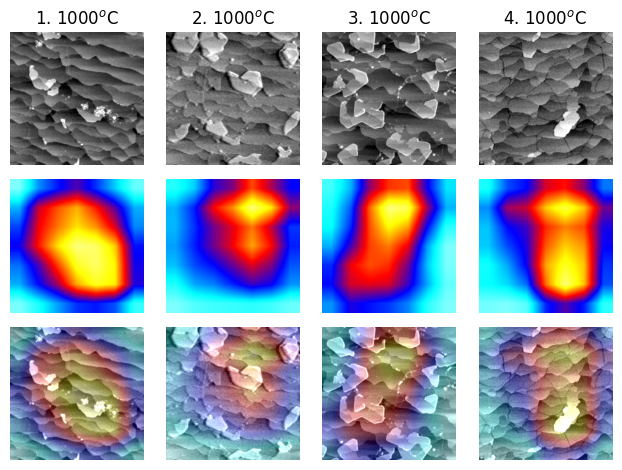

In [91]:
import matplotlib.pyplot as plt
images_indices_1000 = train_correctly_predicted[2][10:]

print(train_X.shape)
_, height, width = train_X[0].shape
j = 0
k = 0
rows = 3
columns = 4

fig, ax = plt.subplots(rows, columns)

#plt.rcParams['axes.titlex'] = 1.0 

for i in range(4):

    image = train_X[images_indices_1000[i]].transpose(1, 2, 0)
    #image = train_X[i].transpose(1, 2, 0)#.to(device)
    features_blobs = []
    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())
    model._modules.get('layer4').register_forward_hook(hook_feature)
    
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

    image_tensor = transform_test(image)
    # add batch dimension
    image_tensor = image_tensor.unsqueeze(0)#.to(device)

    # forward pass through model
    model = model.double()
    outputs = model(image_tensor)
    # get the softmax probabilities
    probs = F.softmax(outputs).data.squeeze()
    print(probs)
    # get the class indices of top k probabilities
    class_idx = topk(probs, 1)[1].int()


    CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)

    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = np.invert(heatmap)*0.3 /255. + image
    #cv2.imwrite('temp_1000_cam.png', result)

    
   
    ax[j, k].imshow(image, cmap='binary')
    ax[j, k].axis('off')
    ax[j, k].set_title(f'{k+1}. 1000$^o$C')# (i)')
    ax[j+1, k].imshow(np.invert(heatmap) /255.,cmap='jet')
    ax[j+1, k].axis('off')
    #ax[j+1, k].set_title('class activation map')
    ax[j+2, k].imshow(result,cmap='jet')
    ax[j+2, k].axis('off')
    #ax[j+2, k].set_title('occlusion attribution')
    k += 1


fig.tight_layout()
   
#plt.savefig("Result/cam_1000.pdf", format="pdf", bbox_inches="tight")   
plt.show()

# Time and Substrate for the Test Set

In [24]:
from collections import Counter

print(Counter(Substrate))

Counter({'Al2O3 c-plane': 123, 'c-Sapphire': 99, 'C-Al2O3 c-plane': 15, 'Al2O3 M-plane': 9, 'Al2O3 A-plane': 7, 'Al2O3 on Al2O3': 5, 'Al2O3': 2, 'Al2O3 c-sapphire': 1, 'Al2O3 c-plane to A': 1})


In [25]:
#print(test_indices[0])
Substrate_dict = {'c-Sapphire':1, 'Al2O3 c-sapphire':1, 'Al2O3 c-plane':1, 'Al2O3 on Al2O3':1, 'C-Al2O3 c-plane':1, 'Al2O3':1,
                  'Al2O3 A-plane':2,'Al2O3 c-plane to A':2, 'Al2O3 M-plane':3}


substrate_numeric = np.array([Substrate_dict[item] for item in Substrate])

test_Substrate = substrate_numeric[test_indices[0]]
test_Time = Time[test_indices[0]]

print(test_Time)
print(".........")
print(test_Substrate)

[ 900. 1440.  900.  900. 1200. 1680.  300.  900. 1200.  120.  600.  120.
  600.  600.  600.  600.  600.  600.  660.  540.  900.  240.  540.  900.
 1200.  600. 1080.]
.........
[1 1 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 1 1 1 2 1 1 1 1 1 1]


In [26]:
test_Substrate_ordered = test_Substrate[image_order]
test_Time_ordered = test_Time[image_order]
print(test_Substrate_ordered)
print(".....")

print(test_Time_ordered)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 3 3 1 1 1 1 1 1 1 1 1]
.....
[ 900. 1440.  900.  900. 1200. 1680.  300.  900. 1200.  120.  600.  600.
  600.  600.  900.  240.  120.  600.  600.  600.  660.  540.  540.  900.
 1200.  600. 1080.]


/tmp/ipykernel_2108896/3943290584.py:52: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "en". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  l = matplotlib.patches.Patch(facecolor=legend_facecolor[i],edgecolor =  legend_edgecolor[i], hatch=legend_hatch[i])


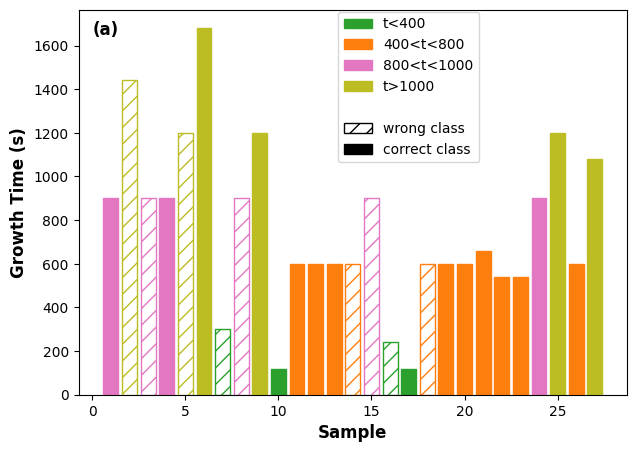

In [27]:
from pylab import *

from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

fig, ax = plt.subplots(figsize=(7.08, 5))

color_dict = {0:'none', 400:'tab:green', 800:'tab:orange', 1000:'tab:pink', 1200:'tab:olive'}

def time_range(time):
   
    if time <400:
        return 400
    elif time<800:
        return 800
    elif time < 1000:
        return 1000
    elif time > 1000:
        return 1200

def time_bar_color(label_pred_match, test_Time_ordered):
    time_color=[]
    
    for index, item in enumerate(label_pred_match):
        
        if item == 0:
            time_color.append(0)
        elif item==1:
            time_color.append(time_range(test_Time_ordered[index]))
    return time_color


hatches_dict = {0:'//', 1:None}

edgecolor=[color_dict[time_range(item)] for item in test_Time_ordered]

hatch=[hatches_dict[item]for item in label_pred_match]

time_color = time_bar_color(label_pred_match, test_Time_ordered)
color = [color_dict[item] for item in time_color]
#color = [color_dict[time_range(item)] for item in test_Time_ordered]



legend_facecolor = ['tab:green', 'tab:orange', 'tab:pink', 'tab:olive', 'none', 'none', 'black']
legend_edgecolor = ['tab:green', 'tab:orange', 'tab:pink', 'tab:olive', 'none', 'black', 'black' ]
legend_hatch = ['none', 'none', 'none', 'none','none', '//', 'none']
legend_label = ['t<400', '400<t<800', '800<t<1000', 't>1000', '', 'wrong class', 'correct class']
legend_artists = []
for i in range(7):
   
    l = matplotlib.patches.Patch(facecolor=legend_facecolor[i],edgecolor =  legend_edgecolor[i], hatch=legend_hatch[i])
    
    legend_artists.append(l)
    
 

#plt.plot([i for i in range(1, len(test_Time_ordered) +1)], test_Time_ordered,'r')
ax.bar([i for i in range(1, len(test_Time_ordered) +1)], test_Time_ordered, hatch=hatch,color=color,edgecolor=edgecolor)
ax.set_xlabel('Sample', fontweight='bold', fontsize=12)
ax.set_ylabel('Growth Time (s)', fontweight='bold', fontsize=12)
ax.text(0, 1650, '(a)',fontweight='bold', fontsize=12)
#plt.legend(custom_lines, ['t<400', '400<t<800', '800<t<1000', 't>1000'])
fig.legend(legend_artists,legend_label, bbox_to_anchor=(0.7, 0.89), loc='upper right')
plt.savefig("Result/Growth_time_test.pdf", format="pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_2108896/3818657048.py:31: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "en". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  l = matplotlib.patches.Patch(facecolor=legend_facecolor[i],edgecolor =  legend_edgecolor[i], hatch=legend_hatch[i])


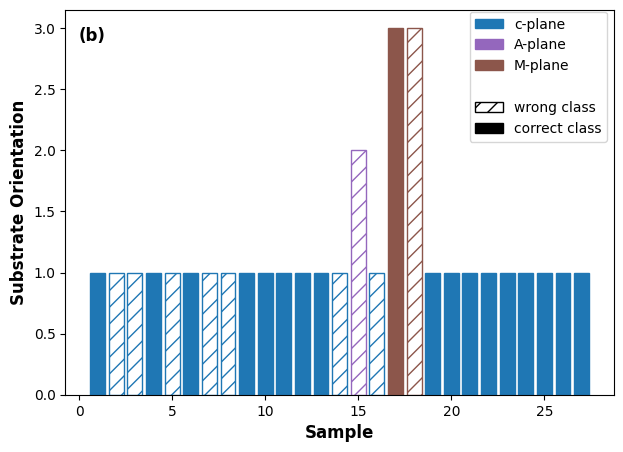

In [28]:
fig, ax = plt.subplots(figsize=(7.08, 5))

def bar_color(label_pred_match, test_Substrate_ordered):
    substrate_color=[]
    
    for index, item in enumerate(label_pred_match):
        
        if item == 0:
            substrate_color.append(0)
        elif item==1:
            substrate_color.append(test_Substrate_ordered[index])
    return substrate_color

color_dict = {0:'none', 1:'tab:blue', 2:'tab:purple', 3:'tab:brown'}
hatches_dict = {0:'//', 1:None}

edgecolor=[color_dict[item] for item in test_Substrate_ordered]
hatch=[hatches_dict[item]for item in label_pred_match]

substrate_color = bar_color(label_pred_match, test_Substrate_ordered)
color = [color_dict[item] for item in substrate_color]


legend_facecolor = ['tab:blue', 'tab:purple', 'tab:brown', 'none', 'none', 'black']
legend_edgecolor = ['tab:blue', 'tab:purple', 'tab:brown', 'none', 'black', 'black' ]
legend_hatch = ['none', 'none', 'none', 'none', '//', 'none']
legend_label = ['c-plane', 'A-plane', 'M-plane', '', 'wrong class', 'correct class']
legend_artists = []
for i in range(6):
   
    l = matplotlib.patches.Patch(facecolor=legend_facecolor[i],edgecolor =  legend_edgecolor[i], hatch=legend_hatch[i])
    
    legend_artists.append(l)


ax.bar([i for i in range(1, len(test_Substrate_ordered) +1)], test_Substrate_ordered, hatch=hatch,color=color,edgecolor=edgecolor)#, label=[label_dict[item] for item in test_Substrate_ordered])
ax.set_xlabel('Sample', fontweight='bold', fontsize=12)
ax.set_ylabel('Substrate Orientation', fontweight='bold', fontsize=12)
ax.text(0, 2.9, '(b)',fontweight='bold', fontsize=12)

fig.legend(legend_artists,legend_label, bbox_to_anchor=(0.9, 0.89), loc='upper right')#,bbox_to_anchor=(1.03, 0.89), loc='outside right upper')
plt.savefig("Result/Substrate_test.pdf", format="pdf", bbox_inches="tight")
plt.show()

Text(0, 0.5, 'Growth Time')

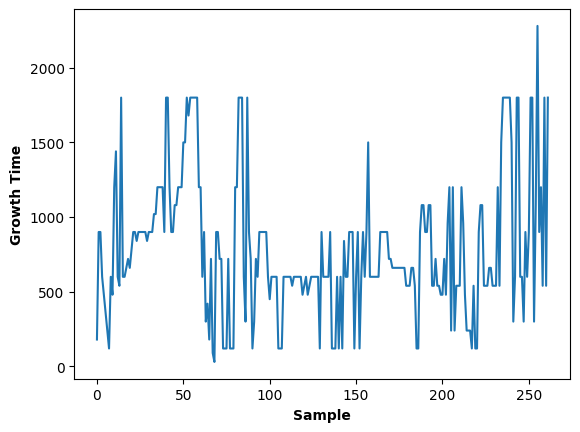

In [62]:
plt.plot([i for i in range(len(Time))], Time)
plt.xlabel('Sample', fontweight='bold')
plt.ylabel('Growth Time', fontweight='bold')

# Embedding Images in 2d PCA

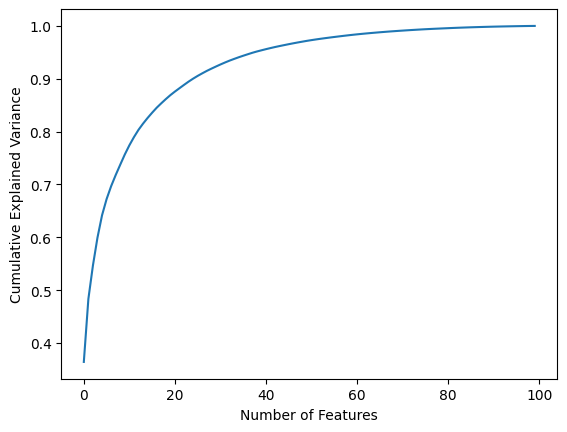

<Figure size 640x480 with 0 Axes>

In [5]:
from sklearn.decomposition import PCA
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
##%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

#import seaborn as sns; sns.set()

pca = PCA().fit(features)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.show()
plt.clf()

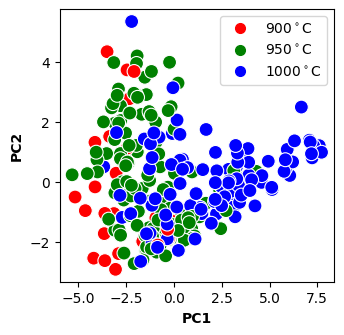

In [29]:
pca = PCA(2)  # project from 64 to 2 dimensions 106(0.40)

#Train_X = pca.fit_transform(train_X)
pca.fit(features)
#Test_X = pca.fit_transform(test_X)
features_2d = pca.transform(features)

class_dict = {0:900,1:950, 2:1000}
class_color = {0:'r', 1:'g', 2:'b'}


#hue = [class_dict[item] for item in T_target],
colors = {900: 'red', 950: 'green', 1000: 'blue'}

fig, ax = plt.subplots(figsize=(3.54, 3.54))


# drawing the plot
#sns.barplot(x, y, ax=ax)

sns.scatterplot(x = features_2d[:, 0], y = features_2d[:, 1], hue = [class_dict[item] for item in T_target],palette = colors, s=100, ax=ax)


custom = [Line2D([], [], marker='.',markersize=14, color='r', linestyle='None'),
          Line2D([], [], marker='.',markersize=14, color='g', linestyle='None'),
         Line2D([], [], marker='.', markersize=14,color='b', linestyle='None')]

#fig = plt.figure(figsize=(8,5))

plt.legend(custom, ['900$^\circ$C', '950$^\circ$C', '1000$^\circ$C'], loc='upper right')

plt.xlabel('PC1',fontweight='bold')
plt.ylabel('PC2',fontweight='bold')
plt.savefig("Result/class_pca.pdf", format="pdf", bbox_inches="tight")
plt.show()

/noether/s0/iam5249/anaconda3/envs/torchvision/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


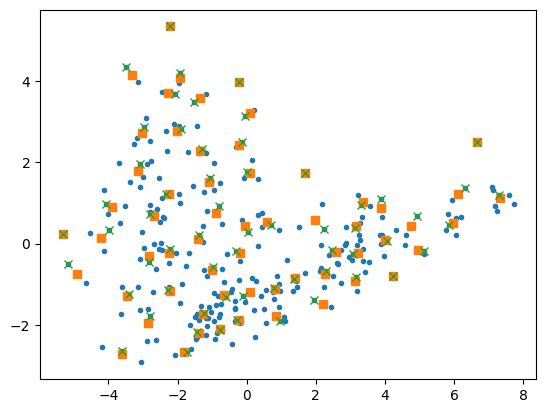

In [16]:
from sklearn import cluster
from sklearn_extra.cluster import KMedoids
#k-medoids

x = features_2d
km = cluster.KMeans(n_clusters=60).fit(x)
#km = KMedoids(n_clusters=50).fit(x)
centers = km.cluster_centers_

c_ids = []
for i in range(km.n_clusters):
#for i in range(40):
    this_id = np.argmin(np.linalg.norm(centers[i] - x, axis=1))
    c_ids.append(this_id)

fig, ax = plt.subplots()
ax.plot(x[:, 0], x[:, 1], '.')
ax.plot(*centers[:, :2].T, 's')
ax.plot(*x[c_ids].T, 'x')
plt.show()

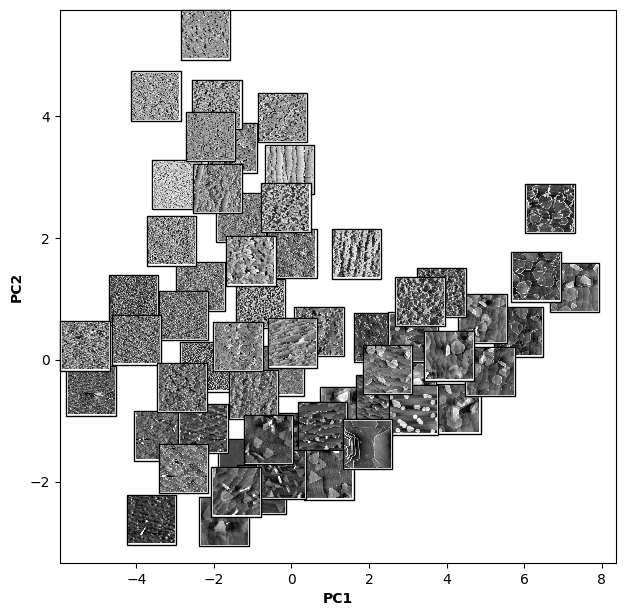

In [30]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
fig, ax = plt.subplots(figsize=(7.18,7.18))
ax.plot(x[:, 0], x[:,1], '.',color='white')
ax.plot(*centers[:, :2].T, '.',color='white')
ax.plot(*x[c_ids].T, 'x')

#ax.imshow(all_afm[i], cmap=plt.get_cmap('gray'), vmin=0, vmax= 12)

for i in c_ids:
    im = OffsetImage(X[i].transpose(1, 2, 0),  zoom=0.15)#cmap=plt.get_cmap('gray'),
    #im.set
    img = im.get_children()[0]; img.set_clim(vmin=0, vmax=0)
    im.image.axes = ax
    ab = AnnotationBbox(im, x[i], frameon=True, pad=0.1)
    ax.add_artist(ab)
plt.xlabel('PC1',fontweight='bold')
plt.ylabel('PC2',fontweight='bold')

plt.savefig("Result/class_pca_image.pdf", format="pdf", bbox_inches="tight")
plt.show()